# File Types

In [1]:
import os

def get_unique_filetypes(directory):
    filetypes = set()

    # Walk through the directory
    for root, _, files in os.walk(directory):
        for file in files:
            # Get the file extension and add it to the set
            _, extension = os.path.splitext(file)
            filetypes.add(extension.lower())

    return filetypes

# Example usage
directory_path = './'
unique_filetypes = get_unique_filetypes(directory_path)

print("Unique file types:")
for filetype in unique_filetypes:
    print(filetype if filetype else "No extension")

Unique file types:
No extension
.png
.meta
.txt
.docx
.py
.tif
.ipynb
.gz
.pptx
.html
.pdf


# Image Dimensions

In [2]:
import os
import numpy as np
from PIL import Image
import tifffile as tiff

def get_image_dimensions(directory):
    dimensions = set()

    # Walk through the directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        array = np.array(img)
                        dimensions.add(array.shape)
                        
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")

            elif file.lower().endswith(('.tif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with tiff.TiffFile(file_path) as img:
                        array = img.asarray()
                        dimensions.add(array.shape)
                        
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")

    return dimensions

# Example usage
directory_path = './'
unique_dimensions = get_image_dimensions(directory_path)

print("Unique image dimensions:")
for dim in unique_dimensions:
    print(dim)
    
print("\n2D image dimensions:")
for dim in unique_dimensions:
    print(tuple(filter(lambda x: x >= 30, dim)))
    

Unique image dimensions:
(14, 3, 104, 689)
(260, 940, 3)
(162, 1020)
(260, 941, 3)
(14, 3, 91, 563)
(10, 3, 107, 762)
(789, 943, 3)
(14, 3, 109, 731)
(12, 3, 110, 697)
(155, 1025)
(13, 3, 162, 1020)
(14, 3, 93, 634)
(18, 3, 89, 737)
(789, 1339, 3)
(14, 3, 76, 611)
(260, 942, 3)
(14, 3, 172, 848)
(11, 3, 113, 728)

2D image dimensions:
(104, 689)
(260, 940)
(162, 1020)
(260, 941)
(91, 563)
(107, 762)
(789, 943)
(109, 731)
(110, 697)
(155, 1025)
(162, 1020)
(93, 634)
(89, 737)
(789, 1339)
(76, 611)
(260, 942)
(172, 848)
(113, 728)


All the 2D images have height <= **172** (the exceptions of sizes (789,1339) and (789, 943) are outputs from tubulaton which aren't cropped yet)

So we can make the net take inputs of size **256 x 256** (to allow for higher resolution data later on)

# Get average/max intensities of images in folder
(i.e. Why can't we just use average image intensity?)

In [14]:
from typing import Callable

from pathlib import Path
import os

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image
import imageio.v3 as iio
import tifffile


In [45]:
# WARNING: CHANGES THE IMAGES!
# Rescale intensities

# image_dir = Path("/Users/karan/MTData/Synthetic/Control")
# scaling_factor = 2/3  

# for filename in os.listdir(image_dir):
#     if filename.endswith(".png"):
#         # Open the image
#         img_path = os.path.join(image_dir, filename)
#         img = Image.open(img_path).convert("L")

#         # Scale the pixel values
#         img = img.point(lambda x: min(255, int(x * scaling_factor)))

#         # Save the modified image
#         img.save(img_path)

In [1]:
def load_image_to_np(image_path : Path) -> np.ndarray:
    # Get the file extension
    _, ext = os.path.splitext(image_path)
    
    # Load image based on file extension
    if ext.lower() in ['.png', '.tif']:
        image_data = iio.imread(image_path)
    elif ext.lower() == '.lsm':
        image_data = tifffile.imread(image_path)
    else:
        raise ValueError("Unsupported file format: {}".format(ext))
    
    return np.array(image_data)

NameError: name 'Path' is not defined

Control has 118 images
Depoly has 118 images


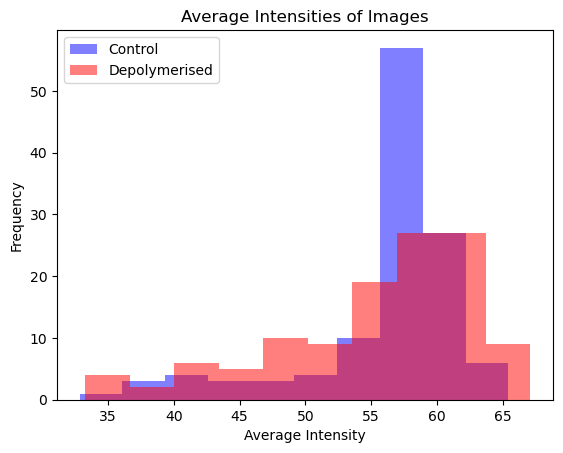

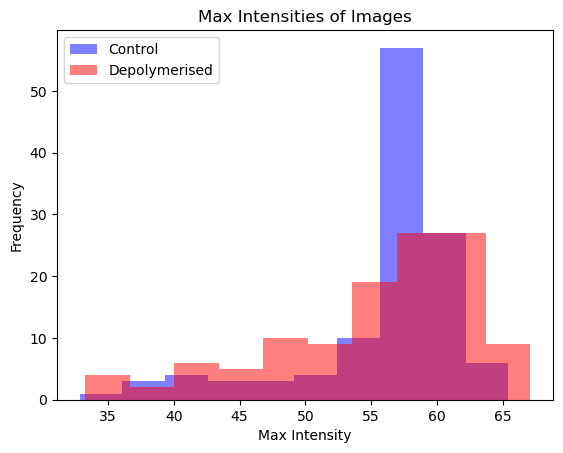

In [47]:
def get_average_intensity(image_file_path : Path) -> float:
    image_array = load_image_to_np(image_file_path)
    
    average_intensity = image_array.mean()

    return average_intensity

def get_max_intensity(image_file_path : Path) -> float:
    image_array = load_image_to_np(image_file_path)
    
    max_intensity = image_array.max()

    return max_intensity

def get_intensities_of_dir(data_dir : Path, aggregation : Callable) -> np.ndarray:
    file_names = os.listdir(data_dir)

    intensities = np.empty(len(file_names))

    for i, file_name in enumerate(file_names):
        image_file_path = data_dir / file_name
        intensities[i] = get_average_intensity(image_file_path)

    return intensities

base_dir = Path("/Users/karan/MTData/Synthetic")
control_dir = base_dir / 'Control/'
depoly_dir = base_dir / 'Depoly'

print(f"Control has {len(os.listdir(control_dir))} images")
print(f"Depoly has {len(os.listdir(depoly_dir))} images")

average_control_intensities = get_intensities_of_dir(control_dir, get_average_intensity)
average_depoly_intensities = get_intensities_of_dir(depoly_dir, get_average_intensity)

# Plot histograms
plt.hist(average_control_intensities, alpha=0.5, color='blue', label='Control')
plt.hist(average_depoly_intensities, alpha=0.5, color='red', label='Depolymerised')

# Add labels and legend
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Average Intensities of Images')
plt.legend()

# Show plot
plt.show()

max_control_intensities = get_intensities_of_dir(control_dir, get_max_intensity)
max_depoly_intensities = get_intensities_of_dir(depoly_dir, get_max_intensity)

# Plot histograms
plt.hist(max_control_intensities, alpha=0.5, color='blue', label='Control')
plt.hist(max_depoly_intensities, alpha=0.5, color='red', label='Depolymerised')

# Add labels and legend
plt.xlabel('Max Intensity')
plt.ylabel('Frequency')
plt.title('Max Intensities of Images')
plt.legend()

# Show plot
plt.show()

In [48]:
image_file_path = Path("/Users/karan/MTData/Oryzalin/2020_07_17/plant 3 root hairs with 20  OZ.lsm")

image = load_image_to_np(image_file_path)

z_slice = 1
c_channel = 0

control_time = 0
depoly_time = 9

control_image = image[control_time, z_slice, c_channel, : , :]
depoly_image = image[depoly_time, z_slice, c_channel, : , :]

print(f"Control image has average intensity: {control_image.mean()}")
print(f"Depoly image has average intensity: {depoly_image.mean()}")

print(f"Control image has max intensity: {control_image.max()}")
print(f"Depoly image has max intensity: {depoly_image.max()}")

Control image has average intensity: 1.442429542541504
Depoly image has average intensity: 1.337021827697754
Control image has max intensity: 142
Depoly image has max intensity: 137


## Examining the Background noise in a Leica SP8 image

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tifffile as tiff

In [10]:
# Path to your .tif file
tif_file_path = '/Users/karan/MTData/test.tif'

# Load the .tif file
with tiff.TiffFile(tif_file_path) as tif:
    # Read the image stack
    images = tif.asarray()

# Display the shape of the array to verify
print(images.shape)

(5, 26, 1024, 1024)


Min intensity: 0
99.5 percentile intensity: 31.0
99.9 percentile intensity: 63.0
Max intensity: 223


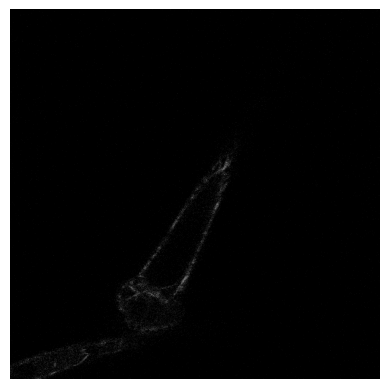

In [40]:
xy_slice = images[0, 10, :, :]

print(f"Min intensity: {xy_slice.min()}")
print(f"99.5 percentile intensity: {np.percentile(xy_slice, 99.5)}")
print(f"99.9 percentile intensity: {np.percentile(xy_slice, 99.9)}")
print(f"Max intensity: {xy_slice.max()}")

plt.imshow(xy_slice, cmap='gray')
plt.axis('off')
plt.show()



### Results of applying Otsu

Threshold: 0.0


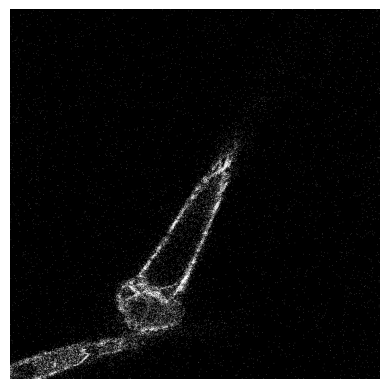

In [46]:
otsu_threshold, processed = cv2.threshold(xy_slice, 0., 1., cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Threshold: {otsu_threshold}")

plt.imshow(processed, cmap='gray')
plt.axis('off')
plt.show()

## Extracting Metadata from .lif file

In [1]:
import numpy as np

from readlif.reader import LifFile
import pprint

In [5]:
# Load the .lif file
lif_file_path = "/Users/karan/MTData/240715_yfp-mt-karan/Trichomes.lif"
lif_file = LifFile(lif_file_path)

metadata = None

target_index = 6
image = list(lif_file.get_iter_image())[target_index]
metadata = image.info

relevant_keys = [
    'bit_depth',
    'scale',
    'scale_n',
    'settings',
]

In [8]:
metadata

{'dims': Dims(x=1024, y=1024, z=26, t=5, m=1),
 'display_dims': (1, 2),
 'dims_n': {1: 1024, 2: 1024, 3: 26, 4: 5},
 'scale_n': {1: 6.929997540968614,
  2: 6.929997540968614,
  3: -3.3500797117966625,
  4: 0.07141964397307479},
 'path': 'New_project/',
 'name': 'Series008',
 'channels': 1,
 'scale': (6.929997540968614,
  6.929997540968614,
  -3.3500797117966625,
  0.07141964397307479),
 'bit_depth': (8,),
 'mosaic_position': [],
 'channel_as_second_dim': False,
 'settings': {'VersionNumber': '15',
  'UserSettingName': 'S52',
  'CanDoSTED': '0',
  'IsSTEDActive': '0',
  'IsSwitchForPulsedStedWithMpActive': '0',
  'UseSystemOptimizedVoxelCalculation': '1',
  'IsUserSettingNameSet': '0',
  'IsHydPulsedModeCoeffntManualActive': '0',
  'XGalvoMovementMode': '0',
  'XGalvoMovementModeName': 'sinus',
  'BitSize': '8',
  'MaxIntegrationTime': '1',
  'ScanMode': 'xyzt',
  'ZUseMode': '1',
  'ZUseModeName': 'z-galvo',
  'ZPosition': '-3.54314188303175E-06',
  'IsSuperZ': '0',
  'ValidBeginStack'

## What are the class ratios in Synthetic Data?

In [3]:
import os
import cv2
import numpy as np

def calculate_class_ratio(label_folder):
    total_black_pixels = 0
    total_white_pixels = 0
    
    for filename in os.listdir(label_folder):
        if filename.endswith('.png'):
            filepath = os.path.join(label_folder, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            
            black_pixels = np.sum(image == 0)
            white_pixels = np.sum(image == 255)
            
            total_black_pixels += black_pixels
            total_white_pixels += white_pixels
    
    total_pixels = total_black_pixels + total_white_pixels
    if total_pixels == 0:
        print("No pixels found in the images.")
        return

    black_ratio = total_black_pixels / total_pixels
    white_ratio = total_white_pixels / total_pixels

    print(f"Black pixel ratio: {black_ratio:.4f}")
    print(f"White pixel ratio: {white_ratio:.4f}")

# Set the path to the folder containing the label images
label_folder = "/Users/karan/MTData/Synthetic_new/Labels"

calculate_class_ratio(label_folder)


Black pixel ratio: 0.9478
White pixel ratio: 0.0522


In [1]:
from pathlib import Path
import os
import imageio.v3 as iio

import numpy as np
import tifffile

def load_image_to_np(image_path : Path) -> np.ndarray:
    # Get the file extension
    _, ext = os.path.splitext(image_path)
    
    # Load image based on file extension
    if ext.lower() in ['.png', '.tif']:
        image_data = iio.imread(image_path)
    elif ext.lower() == '.lsm':
        image_data = tifffile.imread(image_path)
    else:
        raise ValueError("Unsupported file format: {}".format(ext))
    
    return np.array(image_data)

In [2]:
poly = load_image_to_np(Path("/Users/karan/microsegmentation/DemoData/Images/polymerised_rh.png"))[:, :, 0]
depoly = load_image_to_np(Path("/Users/karan/microsegmentation/DemoData/Images/depolymerised_rh.png"))[:, :, 0]

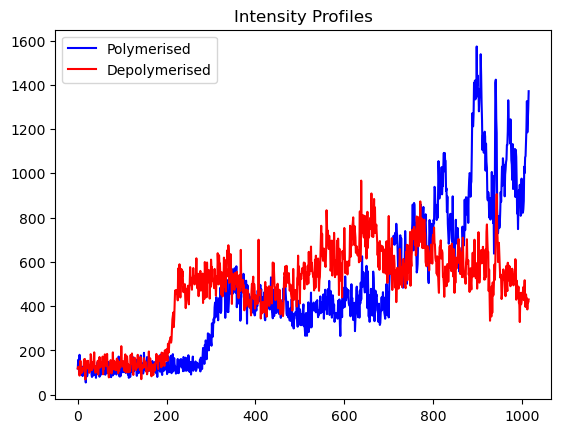

In [8]:
import matplotlib.pyplot as plt

plt.plot(np.arange(poly.shape[1]), poly.sum(axis=0), color='blue', label='Polymerised')
plt.plot(np.arange(depoly.shape[1]), depoly.sum(axis=0), color='red', label='Depolymerised')

plt.legend()

plt.title('Intensity Profiles')

# plt.hist(poly.flatten(), bins=50, color='green', alpha=0.5)
# plt.hist(depoly.flatten(), bins=50, color='red', alpha=0.5)
plt.show()

In [14]:
from scipy.ndimage import minimum_filter

filtered_poly = minimum_filter(poly, size=4, mode='constant', cval=np.inf)
filtered_depoly = minimum_filter(depoly, size=4, mode='constant', cval=np.inf)

58

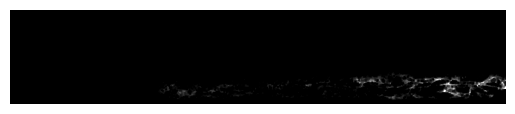

In [27]:
plt.imshow(filtered_poly, cmap='gray', vmax=30)
plt.axis('off')
filtered_poly.max()

17

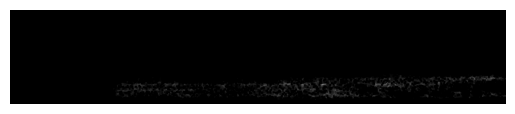

In [28]:
plt.imshow(filtered_depoly, cmap='gray', vmax=30)
plt.axis('off')
filtered_depoly.max()

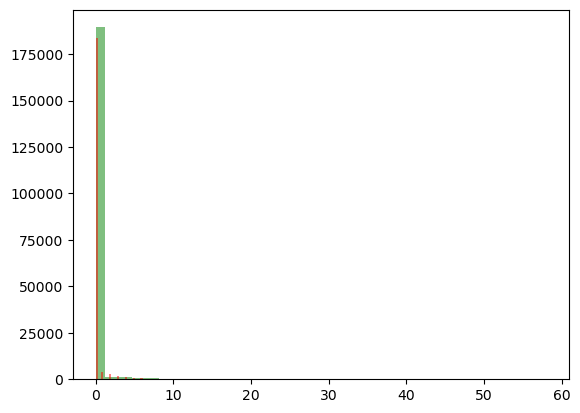

15.0

In [24]:
plt.hist(filtered_poly.flatten(), bins=50, color='green', alpha=0.5)
plt.hist(filtered_depoly.flatten(), bins=50, color='red', alpha=0.5)
plt.show()

np.quantile(filtered_poly, 0.998)